# Switchpoints in agent crowding with Station Sim

In this notebook we have a look at how find switchpoints in a simple simulation of passenger crowding in a train station. This acheived using the Bayesian Inference library pymc. By find areas with clear switchpoints we can identify areas in the simulation which would be useful for predicting crowding in the simulation as a whole. This notebook is concerned only with a single example of an area of crowding which is manually selected. In future work the selection process will be automated by comparing the results of analysis of many areas in the simulation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import pandas as pd
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True) # for local plotly plots

Our Station simulation outputs the position of every agent in the simulation at every timepoint in a .csv file. In addition the speed of the agent and the exit which the agent is aiming for is also recorded

In [2]:
data_file = "../simulation_outputs/state_data1527287042351.txt"  # change this to your requuired data file

sim_df = pd.read_csv(data_file)
sim_df .head()

step      agent  x_pos  y_pos  speed     exit
0     0  Person: 1    1.0   23.0    0.0  Exit: 2
1     0  Person: 2    1.0   25.0    0.0  Exit: 2
2     0  Person: 3    1.0   27.0    0.0  Exit: 2
3     0  Person: 4    1.0   73.0    0.0  Exit: 1
4     0  Person: 5    1.0   75.0    0.0  Exit: 1

Here we define a function to plot the position of the agents a given step intervals

In [3]:
def sim_plotly(df, n_steps):
    
    num_of_steps = len(set(df["step"]))
    choices = range(0, num_of_steps, n_steps)

    x_steps = []
    y_steps = []
    for i in choices:
        x_steps.append(df[df["step"]==i]["x_pos"].as_matrix())
        y_steps.append(df[df["step"]==i]["y_pos"].as_matrix())


    data = [dict(
            visible = False,
            type = 'scatter',
            mode = 'markers',
            x = x_steps[i],
            y = y_steps[i]) for i in range(0, len(choices))]
    data[0]['visible'] = True

    steps = []
    for i in range(len(data)):
        step = dict(
            method = 'restyle',
            args = ['visible', [False] * len(data)],
        )
        step['args'][1][i] = True # Toggle i'th trace to "visible"
        steps.append(step)

    sliders = [dict(
        active = 0,
        currentvalue = {"prefix": "Frequency: "},
        pad = {"t": 50},
        steps = steps
    )]

    layout = dict(sliders=sliders,
                  title="Station Sim",
                  xaxis = dict(range = [0, 200],
                              title="x coordianate",
                              showgrid=True,
                              autotick=False,
                              tick0=0,
                              dtick=10),
                  yaxis = dict(range = [100, 0],
                              title = "y coordinate",
                              showgrid=True,
                              autotick=False,
                              tick0=0,
                              dtick=10))

    fig = dict(data=data, layout=layout)

    iplot(fig)

We can see the position of the agents at every 50 steps below

In [4]:
sim_plotly(sim_df, 50)

For our analysis we are interested in areas of crowding. We can see from the plot that significant crowding occurs at the coorodinates x: 60-80, y: 50-70. We can subset this area and plot it as before.

In [5]:
subset_df = sim_df[np.logical_and(
                    np.logical_and(sim_df["x_pos"] > 60, 
                                   sim_df["x_pos"] < 80),
                    np.logical_and(sim_df["y_pos"] > 50,
                                   sim_df["y_pos"] < 70))]
sim_plotly(subset_df, 50)

For our switch point analysis we first aggregate the data to show the number of agents in our defined area per step.

In [6]:
counts = subset_df.groupby("step").size() # aggregate to count
all_steps = pd.DataFrame({"step" : sorted(list(set(sim_df["step"])))})

count_data_df = pd.merge(all_steps,
                         pd.DataFrame({"step" : counts.index, "count" : counts}),
                         on="step", how="left").fillna(0)

count_data = count_data_df["count"]
# count_data = counts  # To discard 0s

n_count_data = len(count_data) # for convinience later


We can see the progression of crowding in the plot below.

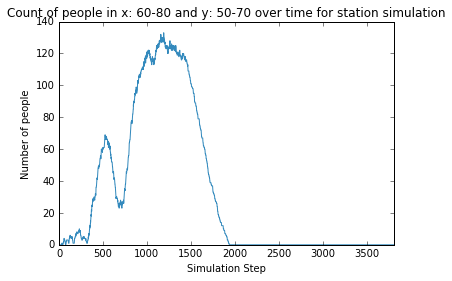

In [7]:
# look at count data
plt.plot(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Simulation Step")
plt.ylabel("Number of people")
plt.title("Count of people in x: 60-80 and y: 50-70 over time for station simulation")
plt.xlim(0, n_count_data)
plt.show()

We use pymc to for our analysis. The model we use defines three distributions (lambda 1-3) used to describe the amount of crowding for three time periods of our simulation. Two switchpoint distributions (tau 1 and 2) define the points at which the timeperiods end and therefore where the lamdadisribution uses to represent crouding change. 

We supply priors for the lambda distributions as an exponential distribution with an alpha of the inverse of the mean. The switchpoint priors are assigned a uniform distribution across all steps.

We then use a Markov chain Monte Carlo algorithm in pym to calulate the posterior distributions.

In [10]:
# pymc
# set hyper-parameter as inverse of data mean
alpha = 1.0 / count_data.mean()
#alpha_1 = 1.0 / count_data[0:2400].mean()
#alpha_2 = 1.0 / count_data[2400:].mean()

# same prior for both lambdas
lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)
lambda_3 = pm.Exponential("lambda_3", alpha)


# Set switchpoint prior as unifrom value for each day
#tau_1 = pm.DiscreteUniform("tau_1", lower=0, upper=1600)
#tau_2 = pm.DiscreteUniform("tau_2", lower=1600, upper=n_count_data)

# Or uniform throughout
tau_1 = pm.DiscreteUniform("tau_1", lower=0, upper=n_count_data)
tau_2 = pm.DiscreteUniform("tau_2", lower=tau_1, upper=n_count_data)


@pm.deterministic
def lambda_(tau_1=tau_1, tau_2=tau_2, lambda_1=lambda_1, lambda_2=lambda_2, lambda_3=lambda_3):
    out = np.zeros(n_count_data)
    out[:tau_1] = lambda_1  # lambda before tau is lambda1
    out[tau_1:tau_2] = lambda_2  # lambda after (and including) tau is lambda2
    out[tau_2:] = lambda_3
    return out

observation = pm.Poisson("obs", lambda_, value=count_data, observed=True)
model = pm.Model([observation, lambda_1, lambda_2, lambda_3, tau_1, tau_2])

# Markov Model Monte Carlo
mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000, 1)

lambda_1_samples = mcmc.trace("lambda_1")[:]
lambda_2_samples = mcmc.trace("lambda_2")[:]
lambda_3_samples = mcmc.trace("lambda_3")[:]
tau_1_samples = mcmc.trace("tau_1")[:]
tau_2_samples = mcmc.trace("tau_2")[:]

 [-----------------100%-----------------] 40000 of 40000 complete in 215.1 sec

We plot the distribution below decribing the crowing in the simulation and switchpoints.

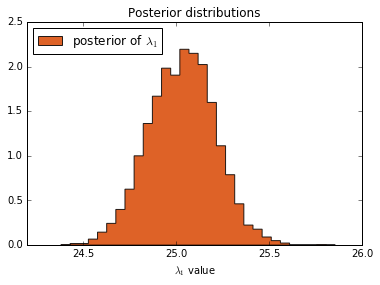

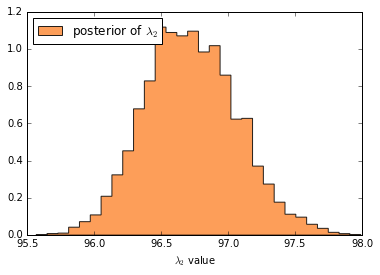

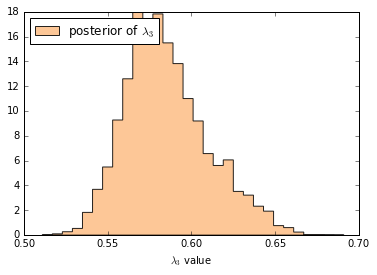

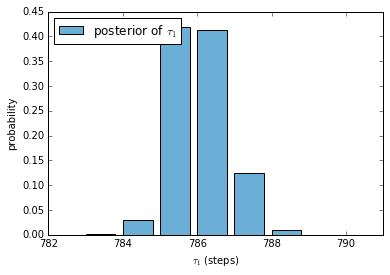

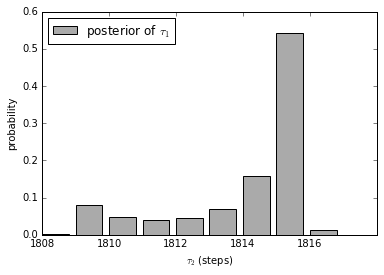

In [11]:
# Histogram of samples

# LAMBDA 1
plt.hist(lambda_1_samples, histtype="stepfilled", bins=30, alpha=0.85,
    label = "posterior of $\lambda_1$", color="#D94701", normed=True)
plt.title(r"""Posterior distributions""")
plt.legend(loc="upper left")
#plt.xlim([0, n_count_data])
plt.xlabel("$\lambda_1$ value")
plt.show()

#LAMBDA 2
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#FD8D3C", normed=True)
plt.legend(loc="upper left")
#plt.xlim([0, n_count_data])
plt.xlabel("$\lambda_2$ value")
plt.show()

#lAMBDA 3
plt.hist(lambda_3_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_3$", color="#FDBE85", normed=True)
plt.legend(loc="upper left")
#plt.xlim([0, n_count_data])
plt.xlabel("$\lambda_3$ value")
plt.show()


def hist_calcs(samples):
    #samples = tau_2_samples
    vals = sorted(list(set(samples)))

    counts = np.zeros(len(vals))
    for num in samples:
        counts[vals.index(num)] += 1
        
    percent = counts / float(samples.shape[0])
    
    return(vals, percent)

# TAU 1
vals, percentages = hist_calcs(tau_1_samples)
plt.bar(vals, percentages, label=r"posterior of $\tau_1$", color="#6BAED6")
plt.xticks(vals[::2])
plt.legend(loc="upper left")
plt.xlabel(r"$\tau_1$ (steps)")
plt.ylabel("probability");
plt.show()

#TAU 2
vals, percentages = hist_calcs(tau_2_samples)
plt.bar(vals, percentages, label=r"posterior of $\tau_1$", color="#AAAAAA")
plt.xticks(vals[::2])
plt.legend(loc="upper left")
plt.xlabel(r"$\tau_2$ (steps)")
plt.ylabel("probability");

plt.show()



It can be seen that the three lamda distribution are all distinct from each other indicating that they clearly represent diffent levels of crowding. The swithpoint distributions also match to points at which we see change occuring in the simulation.

We can see how this compared to the input data below by using our distriburions to estimate crowding in the model over time and plotting it with the input data. This gives us a visual indication of how out maodel fits the data.

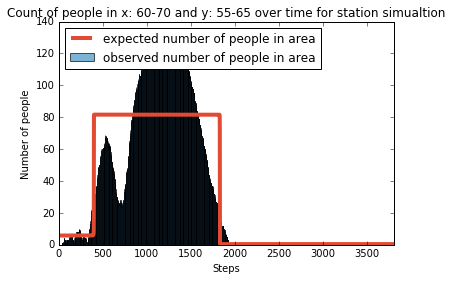

In [11]:

# Sampling from posterior distribution
N = tau_1_samples.shape[0]

expected_area_density = np.zeros(n_count_data)

for step in range(0, n_count_data):
    l1 = step < tau_1_samples
    l2 = np.logical_and(step >= tau_1_samples, step < tau_2_samples)
    l3 = step >= tau_2_samples
    expected_area_density[step] = (lambda_1_samples[l1].sum() +
                                    lambda_2_samples[l2].sum() + lambda_3_samples[l3].sum())/ N

    
plt.plot(range(n_count_data), expected_area_density, lw=4, color="#E24A33",
         label="expected number of people in area")
plt.xlim(0, n_count_data)
plt.xlabel("Steps")
plt.ylabel("Number of people")
plt.title("Count of people in x: 60-70 and y: 55-65 over time for station simualtion")
#plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed number of people in area")

plt.legend(loc="upper left");

plt.show()
